# Can you drink more coffee than your coworkers?

https://fivethirtyeight.com/features/can-you-drink-more-coffee-than-your-coworkers/

> Riddler Headquarters is a buzzing hive of activity. Mathematicians, statisticians and programmers roam the halls at all hours, proving theorems and calculating probabilities. They’re fueled, of course, by caffeine. But the headquarters has just one coffee pot, along with one unbreakable rule: You finish the joe, you make some mo’.
>
> Specifically, the coffee pot holds one gallon of coffee, and workers fill their mugs from it in sequence. Whoever takes the last drop has to make the next pot, no ifs, ands or buts. Every worker in the office is trying to take as much coffee as he or she can while minimizing the probability of having to refill the pot. Also, this pot is both incredibly heavy and completely opaque, so it’s tough to tell how much remains. That means a worker can’t keep pouring until she sees or feels just a drop left. Anyone stuck refilling the pot becomes so frustrated that they throw their cup to the ground in frustration, so they get no coffee that round.
>
> Congratulations! You’ve just been hired to work at Riddler Headquarters. Submit a number between 0 and 1. (It could be 0.9999, or 0.0001, or 0.5, or 0.12345, and so on.) This is the number of gallons of coffee you will attempt to take from the pot each time you go for a cup. If that amount remains, lucky you, you get to drink it. If less remains, you’re out of luck that round; you must refill the pot, and you get no coffee.
> 
> Once I’ve received your submissions, I’ll randomize the order in which you and your colleagues head for the pot. Then I’ll run a lot of simulations — thousands of hypothetical trips to the coffee pot in the Riddler offices. Whoever drinks the most coffee is the ☕ Caffeine King or Queen ☕ of Riddler Headquarters!

In [58]:
%matplotlib inline

In [209]:
from IPython.display import HTML, FileLink
import imageio
import io
import itertools
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import string



def generate_names(n, length=5):
    return [''.join(s) for s in np.random.choice(list(string.ascii_uppercase), size=(n, length))]


def generate_list(n, seed_values=None):
    """Create a list of coworkers with their preferred coffee amount.
    """
    # names = generate_names(n)
    if seed_values is not None:
        values = np.random.uniform(low=0.0, high=1.0, size=n-len(seed_values))
        values = np.concatenate([values, seed_values], axis=0)
    else:
        values = np.random.uniform(low=0.0, high=1.0, size=n)
    return [{'value': value, 'hit': 0, 'miss': 0, 'coffee': 0} for value in values]


def sample_previous_list(values, weights):
    """Randomly sample with replacement based on the weights from the previous simulation.
    """
    values = np.random.choice(values, size=len(values), replace=True, p=weights/weights.sum())
    scale = 10**-4
    values = values + np.random.normal(loc=0.0, scale=scale, size=len(values))
    values = np.clip(values, 0.0, 1.0)
    return [{'value': value, 'hit': 0, 'miss': 0, 'coffee': 0} for value in values]


def run_simulation(entries, n_pots=100):
    n_pot=0
    volume = 1.0
    for idx in itertools.cycle(range(len(entries))):
        entry = entries[idx]
        v = entry['value']
        if v >= volume:
            # no coffee for you
            entry['miss'] += 1
            volume = 1.0
            n_pot += 1
            if n_pot >= n_pots:
                break
        else:
            volume -= v
            entry['hit'] += 1
            entry['coffee'] += v
    df = pd.DataFrame(entries)
    df['n_pots'] = n_pots
    return df



In [208]:
entries = generate_list(n=10**4)
df = run_simulation(entries, n_rounds=10**8)
df.head()

,coffee,hit,miss,value,n_rounds
0,0.958783,1,27173,0.958783,100000000
1,9226.517223,27173,1,0.339547,100000000
2,0.799232,1,27173,0.799232,100000000
3,16055.206983,27173,1,0.590851,100000000
4,0.827265,1,27173,0.827265,100000000


In [210]:
df.groupby(pd.qcut(df['value'], 10)).mean()

,coffee,hit,miss,value,n_rounds
value,,,,,
"(-0.000914, 0.0972]",1258.166164,25978.257,1195.650,0.049107,100000000.0
"(0.0972, 0.198]",3382.853616,23016.305,4157.609,0.147585,100000000.0
"(0.198, 0.297]",5277.704801,21440.213,5733.698,0.246980,100000000.0
"(0.297, 0.396]",6589.908624,18967.390,8206.522,0.348294,100000000.0
"(0.396, 0.496]",7751.714368,17445.660,9728.261,0.445410,100000000.0
"(0.496, 0.595]",8363.378841,15380.438,11793.477,0.544829,100000000.0
"(0.595, 0.695]",9126.661619,14184.783,12989.133,0.645304,100000000.0
"(0.695, 0.797]",9957.823226,13369.567,13804.359,0.745374,100000000.0
"(0.797, 0.899]",9508.458980,11222.830,15951.081,0.848221,100000000.0


''

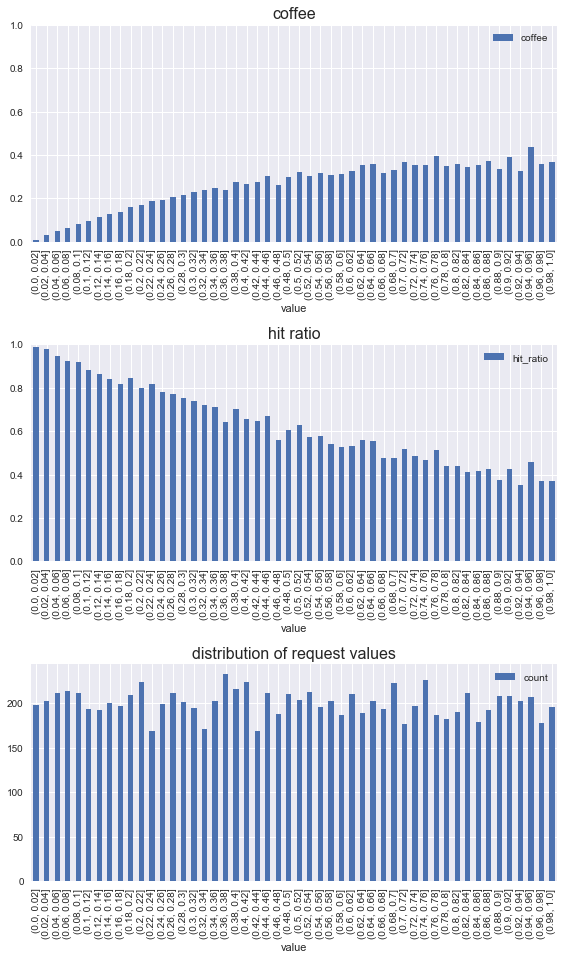

In [211]:
def plot_distributions(df):
    nrows = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(8, 4.5*nrows))
    #cut = pd.qcut(df['value'], 40)
    bins = np.linspace(0, 1, 51)
    cut = pd.cut(df['value'], bins)
    # expected value of coffee
    (
        df
        .assign(coffee=lambda r: r['coffee'] / (r['hit'] + r['miss']))
        .groupby(cut)
        .mean()
        .plot
        .bar(y='coffee', ax=axes[0])
    )
    axes[0].set_title('coffee', fontsize=16)
    axes[0].set_ylim([0, 1.0])
    # hit ratio
    (
        df
        .assign(hit_ratio=lambda r: r['hit'] / (r['hit'] + r['miss']))
        .groupby(cut)
        .mean()
        .plot
        .bar(y='hit_ratio', ax=axes[1])
    )
    axes[1].set_title('hit ratio', fontsize=16)
    axes[1].set_ylim([0, 1.0])
    # distribution of request values
    df.groupby(cut).count().rename(columns={'n_rounds': 'count'}).plot.bar(y='count', ax=axes[2])
    axes[2].set_title('distribution of request values', fontsize=16)
    fig.tight_layout()
    return fig
    
plot_distributions(df)
;

In [213]:
df.sort_values('coffee', ascending=False).head(10)

,coffee,hit,miss,value,n_rounds
8858,27165.643435,27174,0,0.999692,100000000
180,27163.925668,27174,0,0.999629,100000000
4143,27161.937194,27174,0,0.999556,100000000
9580,27158.630199,27173,0,0.999471,100000000
1094,27152.226009,27174,0,0.999199,100000000
5626,27142.675680,27174,0,0.998847,100000000
1772,27135.075607,27174,0,0.998568,100000000
513,27126.508139,27174,0,0.998252,100000000
3904,27116.142030,27174,0,0.997871,100000000
5531,27105.077999,27174,0,0.997464,100000000


In [214]:
df.head(10)

,coffee,hit,miss,value,n_rounds
0,0.958783,1,27173,0.958783,100000000
1,9226.517223,27173,1,0.339547,100000000
2,0.799232,1,27173,0.799232,100000000
3,16055.206983,27173,1,0.590851,100000000
4,0.827265,1,27173,0.827265,100000000
5,26136.445107,27173,1,0.961853,100000000
6,0.201946,1,27173,0.201946,100000000
7,26155.701568,27173,1,0.962562,100000000
8,0.421991,1,27173,0.421991,100000000
9,18766.550950,27173,1,0.690632,100000000


In [215]:
entries = sample_previous_list(df['value'], df['coffee'])
df = run_simulation(entries, n_rounds=10**7)
df.head(10)

,coffee,hit,miss,value,n_rounds
0,1868.411682,2317,0,0.806393,10000000
1,0.000000,0,2317,0.864433,10000000
2,1699.132768,2317,0,0.733333,10000000
3,0.000000,0,2317,0.782456,10000000
4,1430.193414,2317,0,0.617261,10000000
5,0.000000,0,2317,0.413021,10000000
6,1849.559662,2317,0,0.798256,10000000
7,0.000000,0,2317,0.992183,10000000
8,1733.524264,2317,0,0.748176,10000000
9,0.000000,0,2317,0.331643,10000000


''

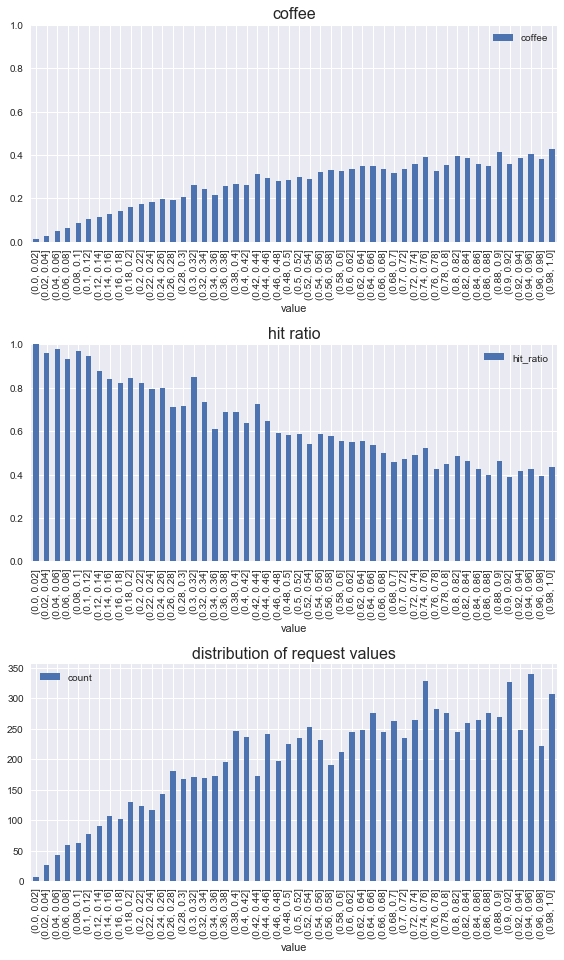

In [216]:
plot_distributions(df)
;

In [218]:
def create_simulation_animation(video_filepath):
    n_entries = 10**4
    n_rounds = n_entries * 10**4
    entries = None
    n_frames = 90
    fps = 3
    video_writer = imageio.get_writer(video_filepath, mode='I', fps=fps)
    
    for i in range(n_frames):
        if entries is None:
            # first time initialization
            entries = generate_list(n=n_entries)
        else:
            # sample the values based on the results of the previous simulation
            entries = sample_previous_list(df['value'], df['coffee'])
        df = run_simulation(entries, n_rounds=n_rounds)
        f = plot_distributions(df)
        buf = io.BytesIO()
        f.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        img = imageio.imread(buf)
        video_writer.append_data(img)
    video_writer.close()
    return df, HTML(
        """
        <video width="976" height="576" controls>
          <source src="{}" type="video/mp4">
        </video>
        """.format(video_filepath)
    )

video_filepath = os.path.expanduser('./simulation_progress.mp4')
df, html = create_simulation_animation(video_filepath)
html

In [204]:
df.sort_values('coffee', ascending=False).head(10)

,coffee,hit,miss,value,n_rounds
7222,19.982143,20,0,0.999107,100000
8164,19.982095,20,0,0.999105,100000
6350,19.982082,20,0,0.999104,100000
3988,19.982023,20,0,0.999101,100000
6004,19.982015,20,0,0.999101,100000
1998,19.981761,20,0,0.999088,100000
8220,19.981703,20,0,0.999085,100000
7718,19.981671,20,0,0.999084,100000
2742,19.981562,20,0,0.999078,100000
5472,19.981535,20,0,0.999077,100000


In [206]:
df.head(10)

,coffee,hit,miss,value,n_rounds
0,19.615506,20,0,0.980775,100000
1,0.000000,0,20,0.993964,100000
2,19.830862,20,0,0.991543,100000
3,0.000000,0,20,0.983844,100000
4,19.850501,20,0,0.992525,100000
5,0.000000,0,20,0.996549,100000
6,19.242253,20,0,0.962113,100000
7,0.000000,0,20,0.998820,100000
8,19.345996,20,0,0.967300,100000
9,0.000000,0,20,0.993819,100000


In [176]:
FileLink(video_filepath)

/home/dennis/workspace/PublicNotebooks/fivethirtyeight/simulation_progress.mp4